In [1]:
import celldancer as cd
import anndata
import pandas as pd
import numpy as np
import scipy as sp
import os

In [2]:
dataset = "IPSC"
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f"{root}/data/{dataset}_pp.h5ad")
df = pd.read_csv(f"{root}/data/celldancer/{dataset}/{dataset}_out.csv")

In [20]:
x = adata.obsm['X_embed'][:, 0]
y = adata.obsm['X_embed'][:, 1]
x_stack = np.stack([x for i in range(962)]).flatten()
y_stack = np.stack([y for i in range(962)]).flatten()

In [23]:
df['embedding1'] = x_stack
df['embedding2'] = y_stack

In [24]:
df.to_csv(f"{root}/data/celldancer/{dataset}/{dataset}_out.csv")

In [25]:
n_neigh = adata.uns['neighbors']['indices'].shape[1]
df = cd.compute_cell_velocity(cellDancer_df=df,
                              projection_neighbor_choice="gene",
                              expression_scale='power10',
                              projection_neighbor_size=n_neigh,
                              speed_up=(100, 100))

Caution! Overwriting the 'velocity' columns.


Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating Trajectories: 100%|██████████| 26910/26910 [00:02<00:00, 10855.66it/s]


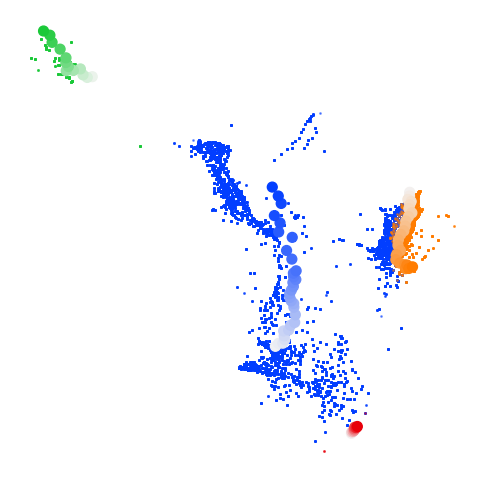

There are 3 clusters.
[0 1 2]


Generating Trajectories: 100%|██████████| 6540/6540 [00:00<00:00, 14570.00it/s]


--- 1372.0644099712372 seconds ---


In [26]:
# estimate pseudotime
dt = 0.05
n_repeats = 10
t_total = {dt: int(10/dt)}
df = cd.pseudo_time(cellDancer_df=df,
                    grid=(30, 30),
                    dt=dt,
                    t_total=t_total[dt],
                    n_repeats=n_repeats,
                    speed_up=(100, 100),
                    n_paths=3,
                    plot_long_trajs=True,
                    psrng_seeds_diffusion=[i for i in range(n_repeats)],
                    n_jobs=6)

In [27]:
df.to_csv(f"{root}/data/celldancer/{dataset}/{dataset}_out.csv")

/scratch/blaauw_root/blaauw1/gyichen/celldancer_env/lib/python3.7/site-packages/celldancer/plotting/cell.py:269: RuntimeWarning: divide by zero encountered in double_scalars
  norm_ratio = distance_grid/max_discance


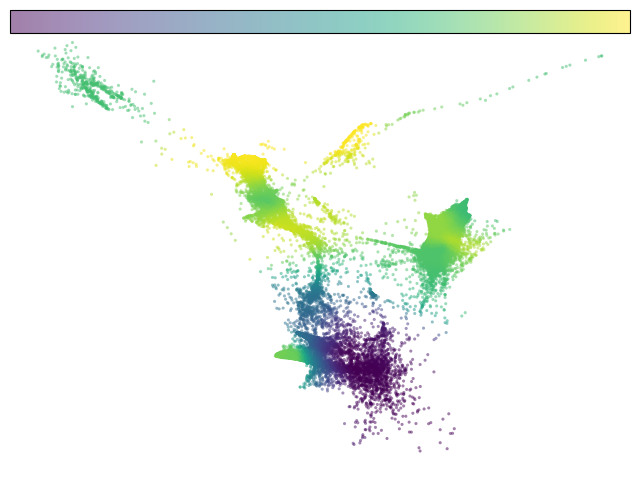

In [30]:
import matplotlib.pyplot as plt
import celldancer.cdplt as cdplt
fig, ax = plt.subplots(figsize=(8,6))
im=cdplt.scatter_cell(ax,
                      df,
                      colors='pseudotime',
                      alpha=0.5,
                      velocity=True)
ax.axis('off')
fig.savefig(f"{root}/data/celldancer/{dataset}/cd_time_{dataset}.png")

# Write results to .h5ad

In [37]:
gene_filt = df['gene_name'].to_numpy().reshape(962, N)[:, 0]

In [42]:
gene_mask = np.array([np.where(adata.var_names == x)[0][0] for x in gene_filt])

In [52]:
N, G = adata.shape
G_filt = 962
alpha = np.ones(adata.shape) * np.nan
beta = np.ones(adata.shape) * np.nan
gamma = np.ones(adata.shape) * np.nan
vu = np.ones(adata.shape) * np.nan
vs = np.ones(adata.shape) * np.nan
time = np.ones(adata.shape) * np.nan

alpha[:, gene_mask] = df["alpha"].to_numpy().reshape(G_filt, N).T
beta[:, gene_mask] = df["beta"].to_numpy().reshape(G_filt, N).T
gamma[:, gene_mask] = df["gamma"].to_numpy().reshape(G_filt, N).T
vu[:, gene_mask] = (df["unsplice_predict"].to_numpy().reshape(G_filt, N)
                    - df["unsplice"].to_numpy().reshape(G_filt, N)).T
vs[:, gene_mask] = (df["splice_predict"].to_numpy().reshape(G_filt, N)
                    - df["splice"].to_numpy().reshape(G_filt, N)).T
time[:, gene_mask] = df["pseudotime"].to_numpy().reshape(G_filt, N).T

adata.layers["cd_alpha"] = alpha
adata.layers["cd_beta"] = beta
adata.layers["cd_gamma"] = gamma
adata.layers["cd_velocity_u"] = vu
adata.layers["cd_velocity"] = vs
adata.obs["cd_time"] = time[:, 0]

data_path = f"{root}/data/celldancer/{dataset}"
adata.write_h5ad(f"{data_path}/{dataset}.h5ad")

# Plotting